# Silhouette

In [1]:
import torch
from torchvision.models import resnet18
from ignite.utils import manual_seed
import pickle

from analyze import *

manual_seed(123)

## Prepare testee samples

sample batch


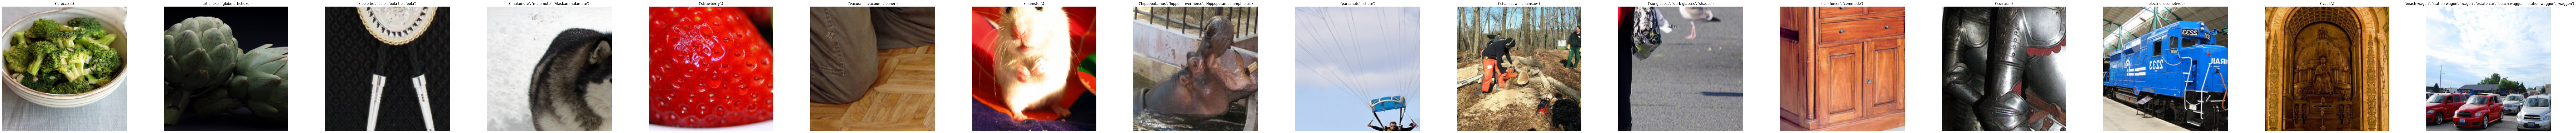

feature map before layer1: torch.Size([16, 64, 112, 112])
feature map between layer1 and layer2: torch.Size([16, 64, 56, 56])


In [2]:
with open('materials/samples/sample_ImageNet', 'rb') as f:
    sample = pickle.load(f)

print(f'sample batch')
visualize_images(sample['batch']['images'],
                 sample['batch']['tags'],
                 sample['batch']['used_normalization'],
                 sample['batch']['classes'])

model = resnet18(pretrained=True)

def prepare_testee_samples(model, batch):
    testee_samples = {}
    
    def extract_feature_map(location):
        def hook(m, i, o):
            testee_samples[location] = o.detach()
        return hook
    
    handle1 = model.relu.register_forward_hook(extract_feature_map('before_layer1'))
    handle2 = model.layer1.register_forward_hook(extract_feature_map('between_layer1_and_layer2'))
    
    model(batch)
    
    handle1.remove()
    handle2.remove()
    
    return testee_samples
    
feature_maps = prepare_testee_samples(model, sample['batch']['images'])

print(f'feature map before layer1: {feature_maps["before_layer1"].size()}')
print(f'feature map between layer1 and layer2: {feature_maps["between_layer1_and_layer2"].size()}')

## Components

### AttentionMapExtractor

In [3]:
from architectures.Silhouette.components_Silhouette import AttentionMapExtractor

def test_AttentionMapExtractor():
    print(f'**AttentionMapExtractor test**')
    print()
    
    layer = AttentionMapExtractor(64, 1000)
    (y, a) = layer(feature_maps['before_layer1'])
    print(f'predicted by AttentionMapExtractor:\n {y.argmax(dim=1)}')
    print(f'ground-truth:\n {sample["batch"]["tags"]}')
    print()
    
    print(f'extracted attention map: {a.size()}')
    print()
    
    return a
    
attention_map = test_AttentionMapExtractor()

**AttentionMapExtractor test**

predicted by AttentionMapExtractor:
 tensor([ 12, 981, 981,  12,  12, 981,  12,  12,  12,  12,  12,  12, 981,  12,
        981,  12])
ground-truth:
 tensor([937, 944, 451, 249, 949, 882, 333, 344, 701, 491, 837, 493, 524, 547,
        884, 436])

extracted attention map: torch.Size([16, 1000, 55, 55])



### compress_attention_map

**compress_attention_map test**

method: max


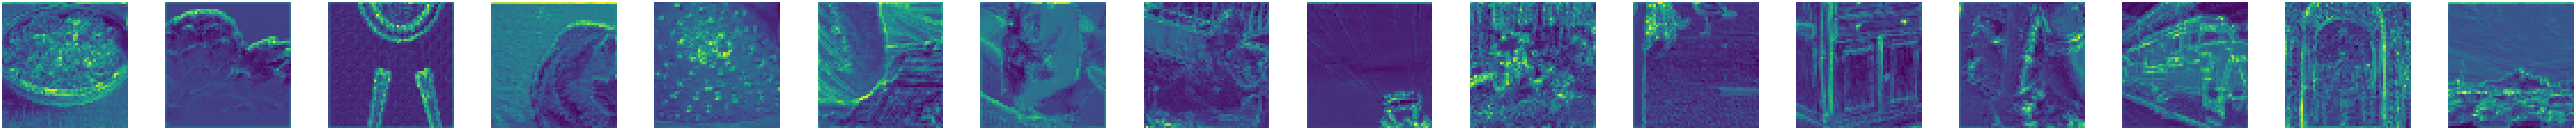

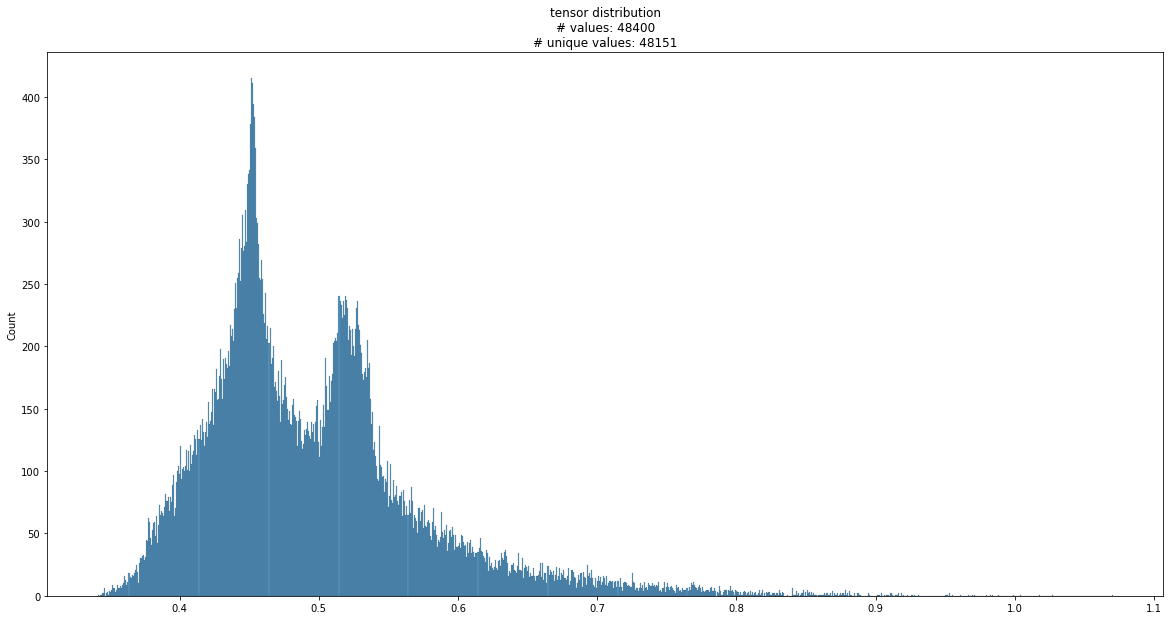

method: avg


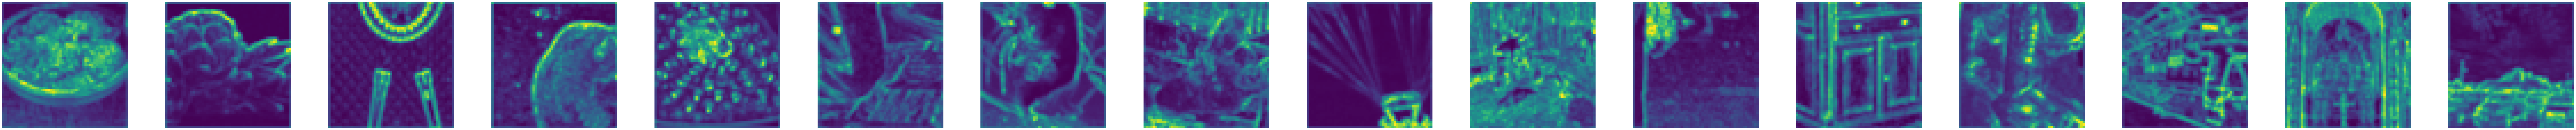

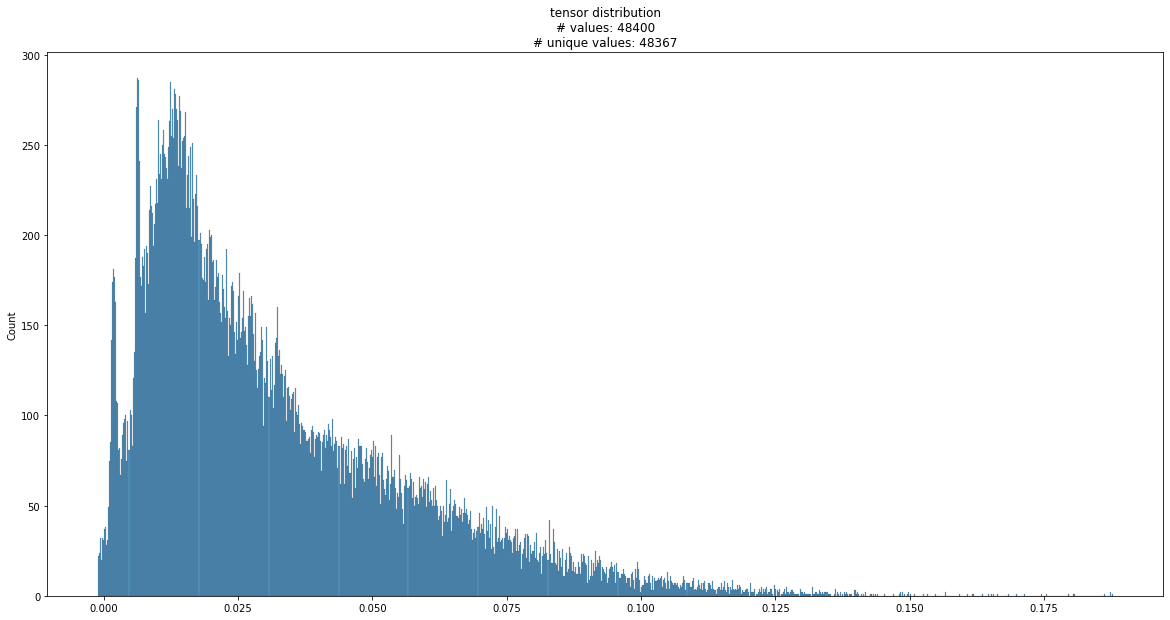

method: top5_activation


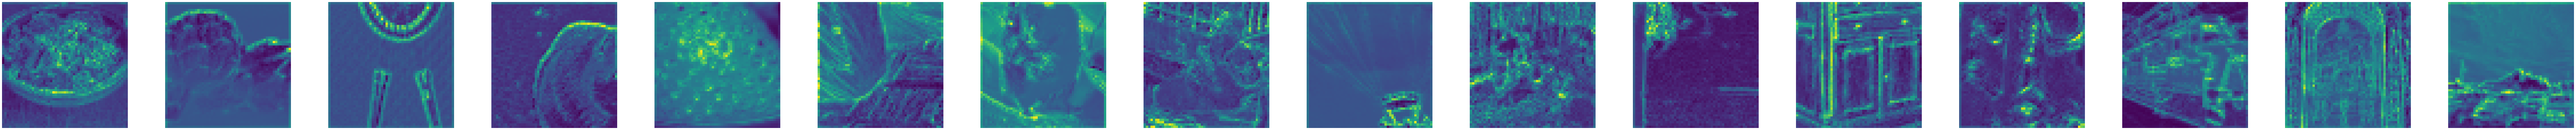

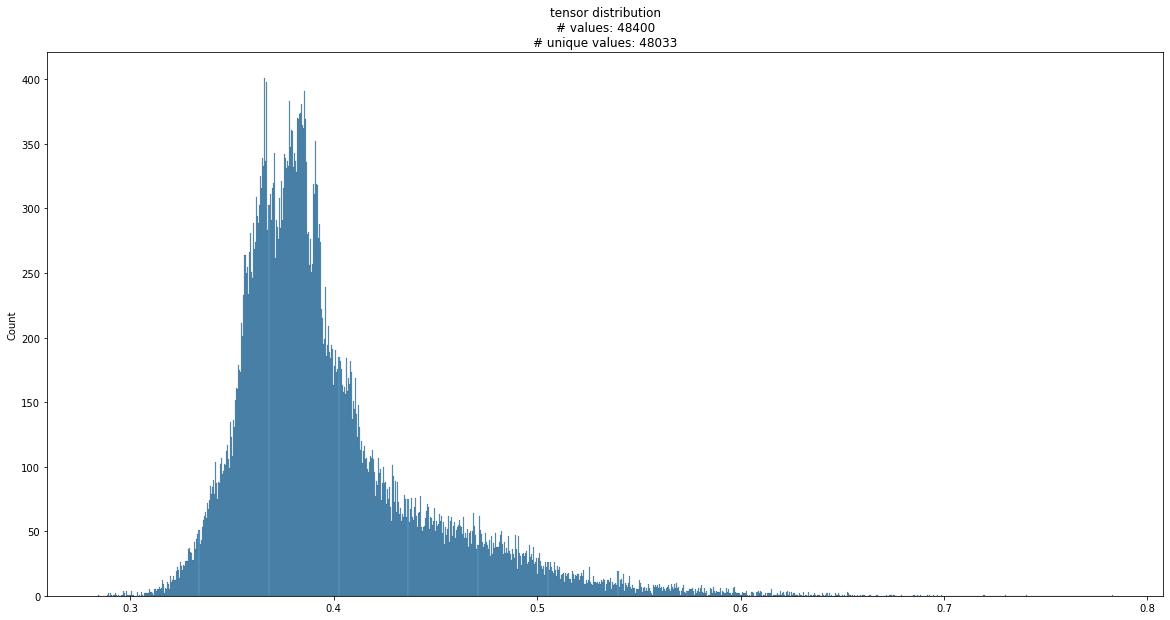

method: top1_deviation_of_activation


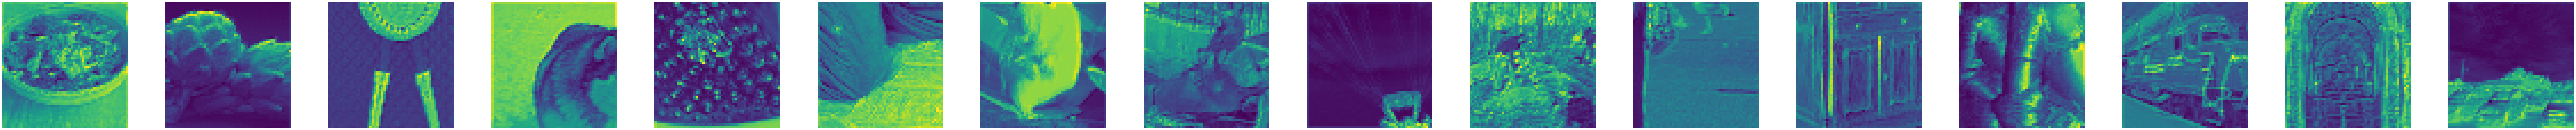

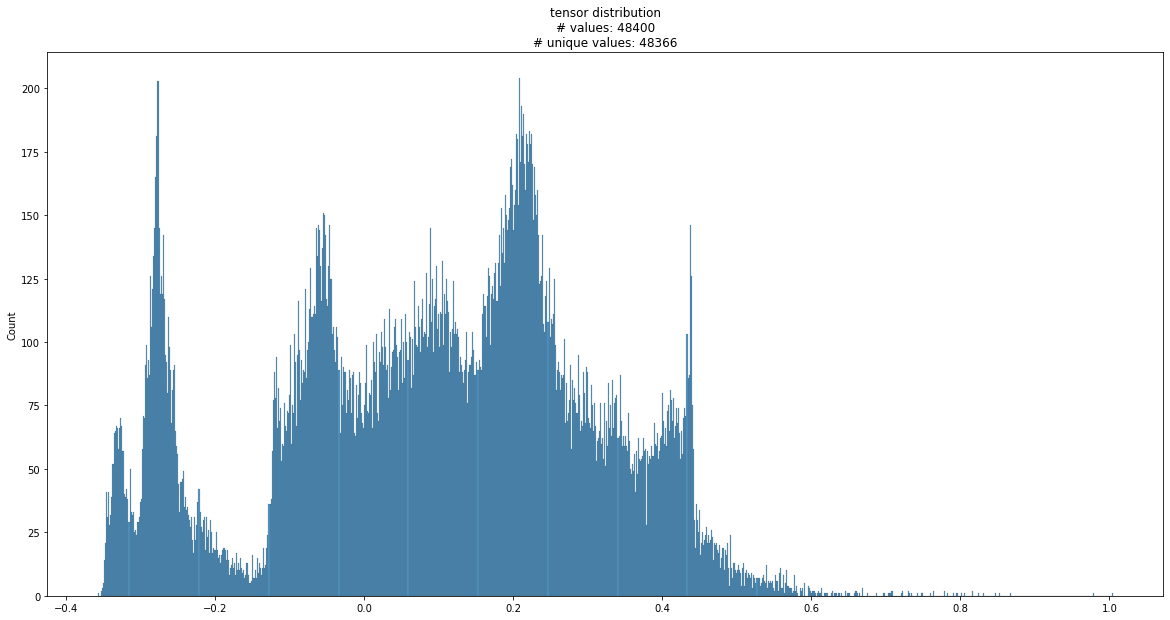

method: top5_deviation_of_activation


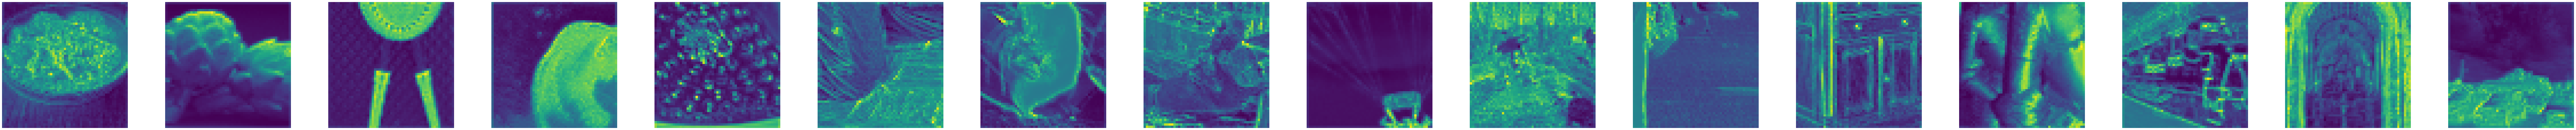

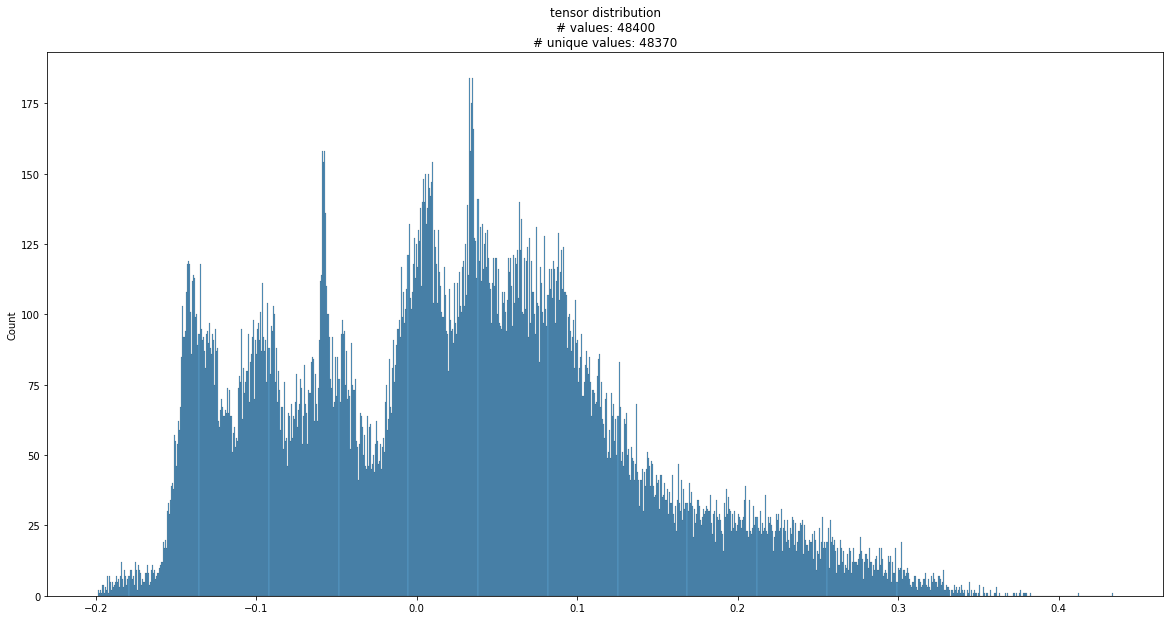

method: random


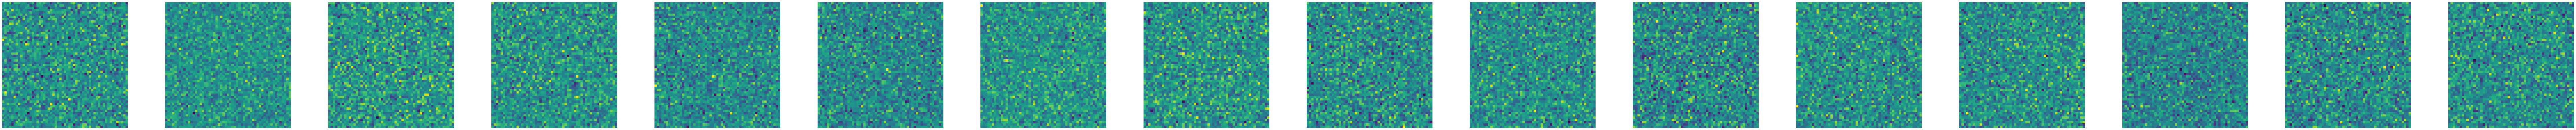

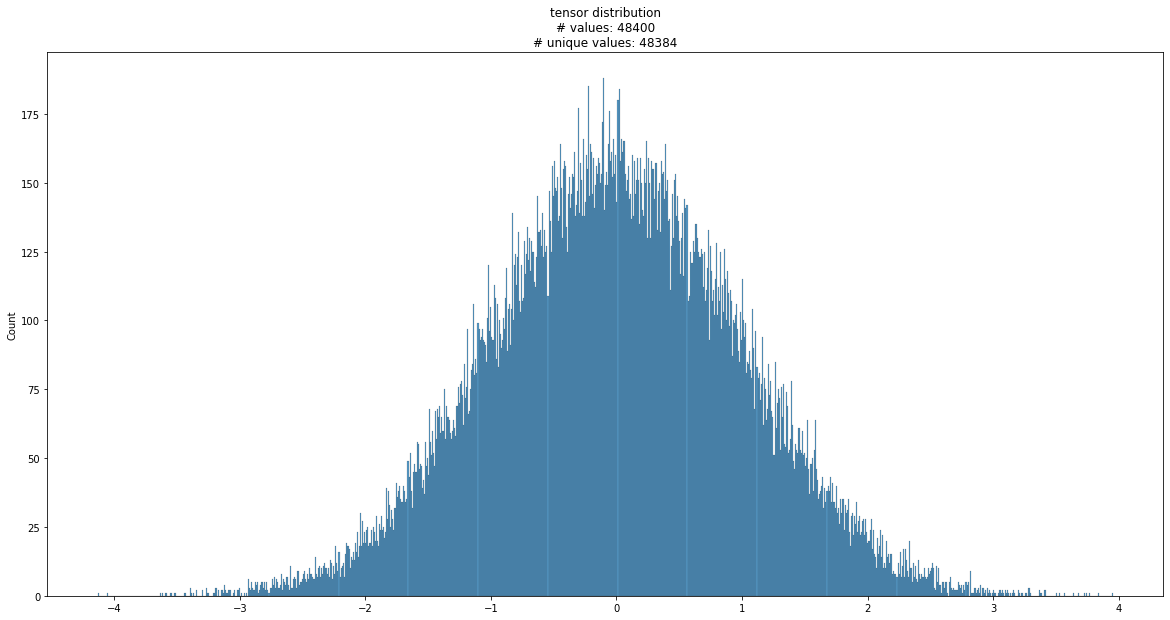

In [4]:
from architectures.Silhouette.components_Silhouette import compress_attention_map

def test_compress_attention_map(attention_map):
    print(f'**compress_attention_map test**')
    print()
    
    print(f'method: max')
    cam_max = compress_attention_map(attention_map, 'max')
    visualize_tensor(cam_max)
    visualize_tensor_distribution(cam_max)
    
    print(f'method: avg')
    cam_avg = compress_attention_map(attention_map, 'avg')
    visualize_tensor(cam_avg)
    visualize_tensor_distribution(cam_avg)
    
    print(f'method: top5_activation')
    cam_top5_act = compress_attention_map(attention_map, 'topk_activation', k=5)
    visualize_tensor(cam_top5_act)
    visualize_tensor_distribution(cam_top5_act)
    
    print(f'method: top1_deviation_of_activation')
    cam_top1_devact = compress_attention_map(attention_map, 'topk_deviation_of_activation', k=1)
    visualize_tensor(cam_top1_devact)
    visualize_tensor_distribution(cam_top1_devact)
    
    print(f'method: top5_deviation_of_activation')
    cam_top5_devact = compress_attention_map(attention_map, 'topk_deviation_of_activation', k=5)
    visualize_tensor(cam_top5_devact)
    visualize_tensor_distribution(cam_top5_devact)
    
    print(f'method: random')
    cam_random = compress_attention_map(attention_map, 'random')
    visualize_tensor(cam_random)
    visualize_tensor_distribution(cam_random)
    
test_compress_attention_map(attention_map)

### AuxiliaryNet

**AuxiliaryNet test**
kept Silhouette(compressed attention map)


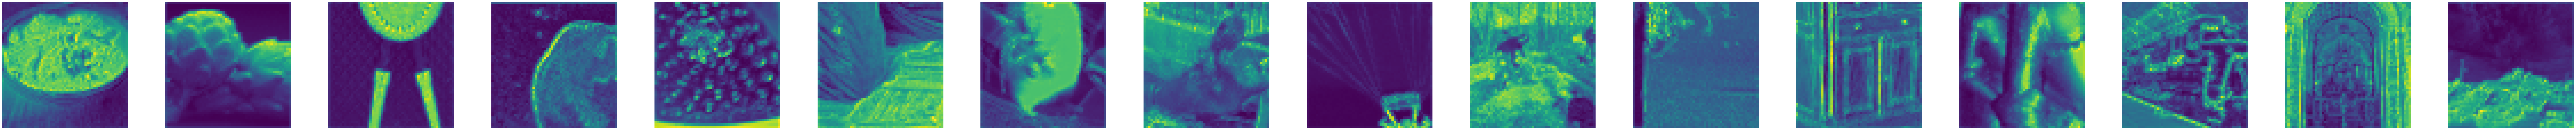

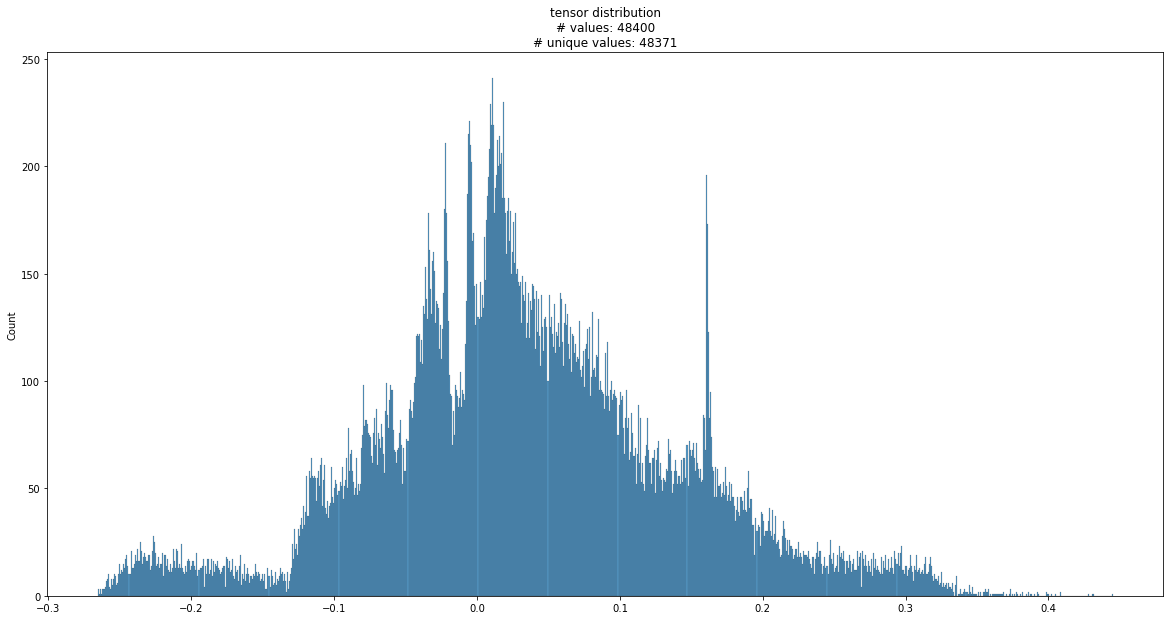

In [5]:
from architectures.Silhouette.components_Silhouette import AuxiliaryNet

def test_AuxiliaryNet():
    print(f'**AuxiliaryNet test**')
    layer = AuxiliaryNet(extractor_config={'in_channels': 64, 'out_channels': 1000},
                         compress_config={'method': 'topk_deviation_of_activation', 'k': 5})
    assert layer.silhouette is None
    layer(feature_maps['before_layer1'])
    assert layer.silhouette is not None
    
    print(f'kept Silhouette(compressed attention map)')
    visualize_tensor(layer.silhouette)
    visualize_tensor_distribution(layer.silhouette)
    
    return layer
    
auxnet = test_AuxiliaryNet()

### encode_policy

In [6]:
from architectures.Silhouette.components_Silhouette import encode_policy

def test_encode_policy():
    print(f'**encode_policy test**')
    policy_list = ['2bit 50%, 3bit 50%',
                   '2bit 50%, 3bit 30%, 4bit 20%',
                   '4bit 50%, 3bit 30%, 2bit 20%']
    for policy in policy_list:
        nbits, quantiles = encode_policy(policy)
        print(f'\tpolicy: {policy}, nbits: {nbits}, quantiles: {quantiles}')
        
test_encode_policy()

**encode_policy test**
	policy: 2bit 50%, 3bit 50%, nbits: [2, 3], quantiles: tensor([0.0000, 0.5000])
	policy: 2bit 50%, 3bit 30%, 4bit 20%, nbits: [2, 3, 4], quantiles: tensor([0.0000, 0.5000, 0.8000])
	policy: 4bit 50%, 3bit 30%, 2bit 20%, nbits: [4, 3, 2], quantiles: tensor([0.0000, 0.5000, 0.8000])


### sectionize_silhouette

**sectionize_silhouette test**

masks generated based on silhouette based on sectioning_policy: 2bit 50%, 3bit 30%, 4bit 20%


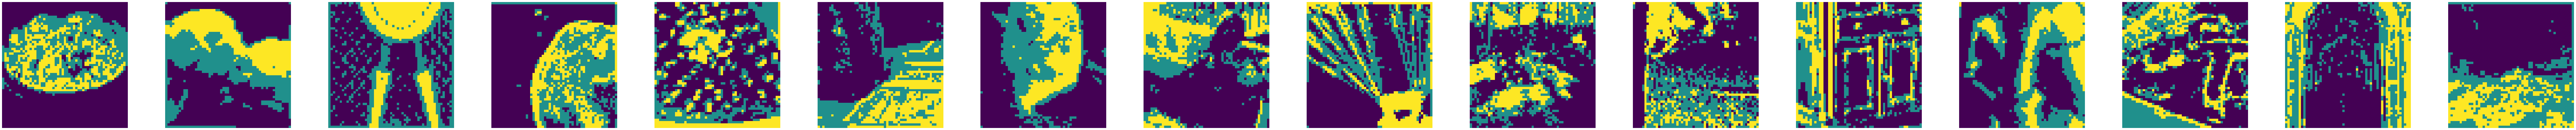

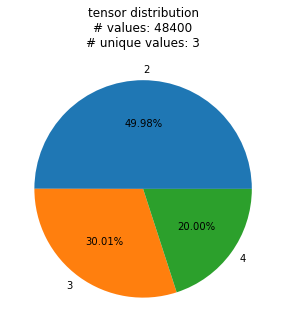


quantile values of aux_net silhouette based on sectioning_policy: 2bit 50%, 3bit 30%, 4bit 20%
2bit: tensor([-0.1317, -0.0809, -0.0587,  0.0025, -0.2653, -0.0492, -0.1020, -0.0407,
        -0.0272, -0.0961, -0.0657, -0.0125, -0.1118, -0.0604, -0.1420, -0.1309]), shape: torch.Size([16])
3bit: tensor([ 0.0749, -0.0341, -0.0278,  0.0363, -0.1860,  0.0268, -0.0019,  0.0852,
        -0.0027,  0.1770,  0.0260,  0.0691,  0.0174,  0.0626,  0.0048, -0.0898]), shape: torch.Size([16])
4bit: tensor([ 0.1796,  0.1081,  0.2557,  0.0625, -0.1127,  0.0819,  0.1602,  0.1459,
         0.0136,  0.2468,  0.0434,  0.1009,  0.1593,  0.1274,  0.1058,  0.0767]), shape: torch.Size([16])


In [7]:
from architectures.Silhouette.components_Silhouette import sectionize_silhouette

def test_sectionize_silhouette(aux_net):
    print(f'**sectionize_silhouette test**')
    print()
    policy = '2bit 50%, 3bit 30%, 4bit 20%'
    nbits, quantiles = encode_policy(policy)
    masks, quantile_values = sectionize_silhouette(aux_net.silhouette, nbits, quantiles)
    
    print(f'masks generated based on silhouette based on sectioning_policy: {policy}')
    visualize_tensor(integrate_mask(masks))
    visualize_tensor_distribution(masks, is_mask=True)
    print()
    
    print(f'quantile values of aux_net silhouette based on sectioning_policy: {policy}')
    for nbit, qv_by_nbit in quantile_values.items():
        print(f'{nbit}bit: {qv_by_nbit}, shape: {qv_by_nbit.shape}')
    
test_sectionize_silhouette(auxnet)

### SilhouetteConv2d

**SilhouetteConv2d test**
simiulate layer1.0.conv1: policy: 2bit 50%, 3bit 30%, 4bit 20%, in_channels: 64, out_channels: 128, options: weight_scaling(X), interpolate before sectioning(X)
mask generated:


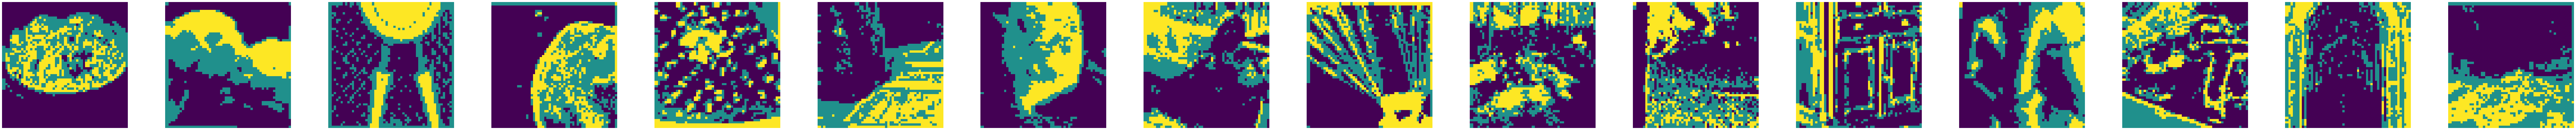

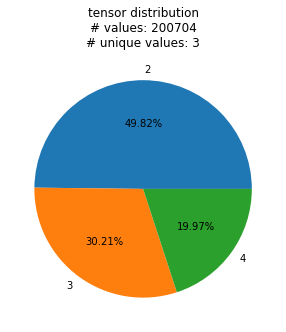


{'2': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1228, 0.1829, 0.2204,  ..., 0.1707, 0.0482, 0.2016],
          [0.2732, 0.2937, 0.2789,  ..., 0.3060, 0.3414, 0.3583],
          ...,
          [0.2908, 0.3330, 0.3471,  ..., 0.2527, 0.2940, 0.3179],
          [0.1530, 0.2268, 0.0353,  ..., 0.2846, 0.3070, 0.2784],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.3801, 0.1849, 0.1551,  ..., 0.0000, 0.0000, 0.0000],
          [0.3745, 0.1832, 0.1648,  ..., 0.1733, 0.0000, 0.0000],
          ...,
          [0.4066, 0.2629, 0.2291,  ..., 0.1393, 0.1787, 0.0000],
          [0.3096, 0.2292, 0.2209,  ..., 0.0465, 0.0614, 0.0000],
          [0.2760, 0.0554, 0.0000,  ..., 0.0167, 0.0466, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 

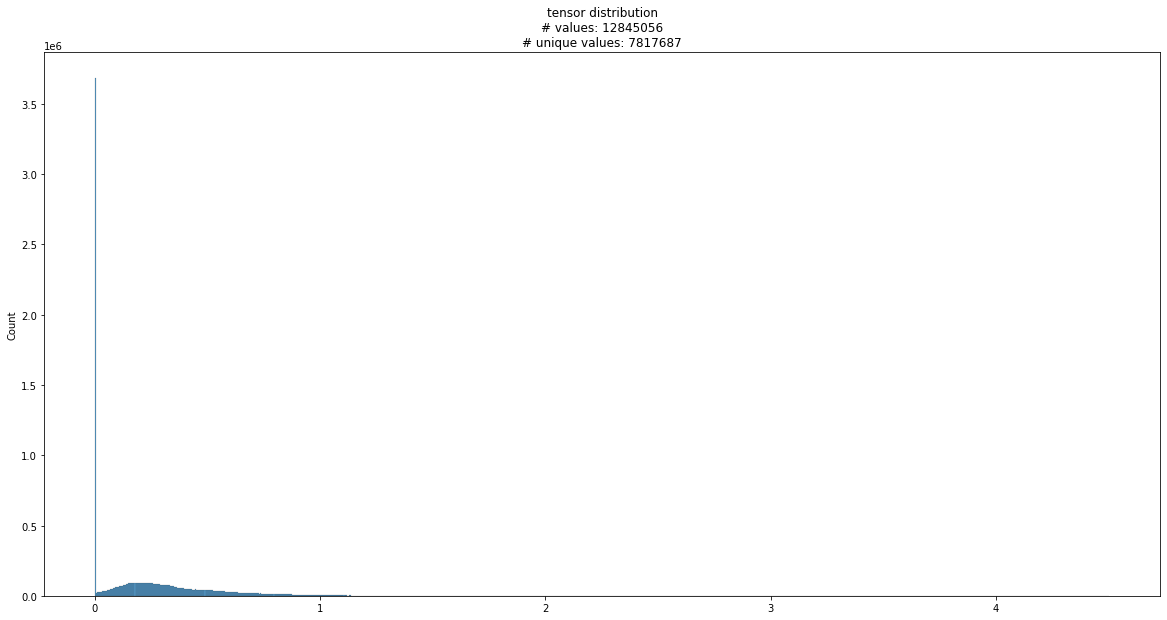

3bit region's value distribution including masked value


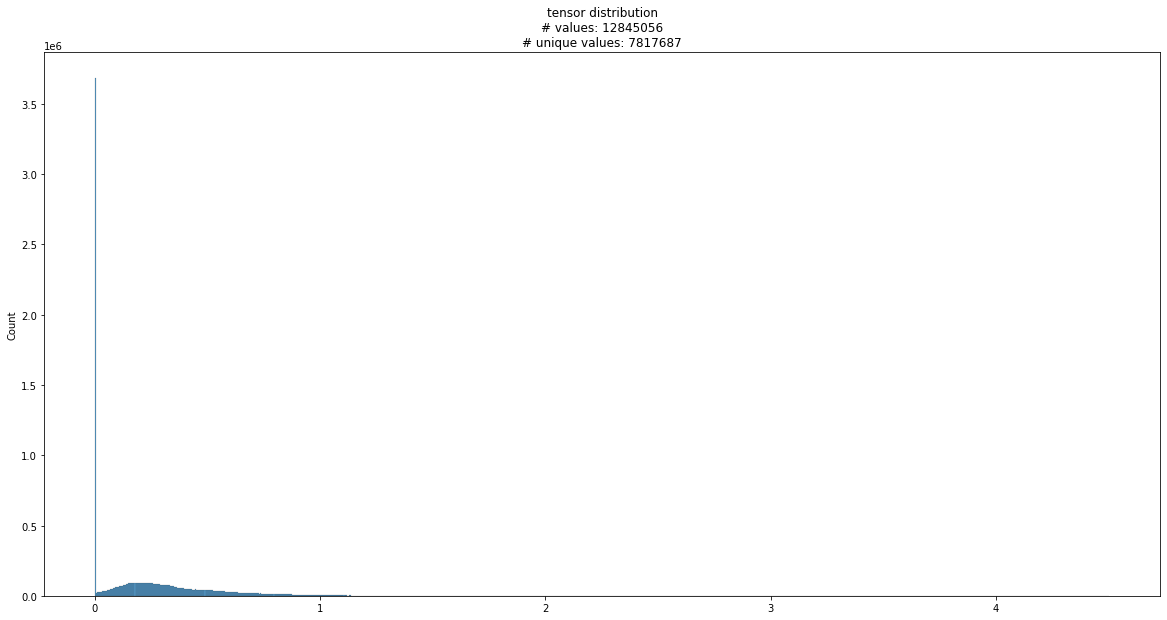

4bit region's value distribution including masked value


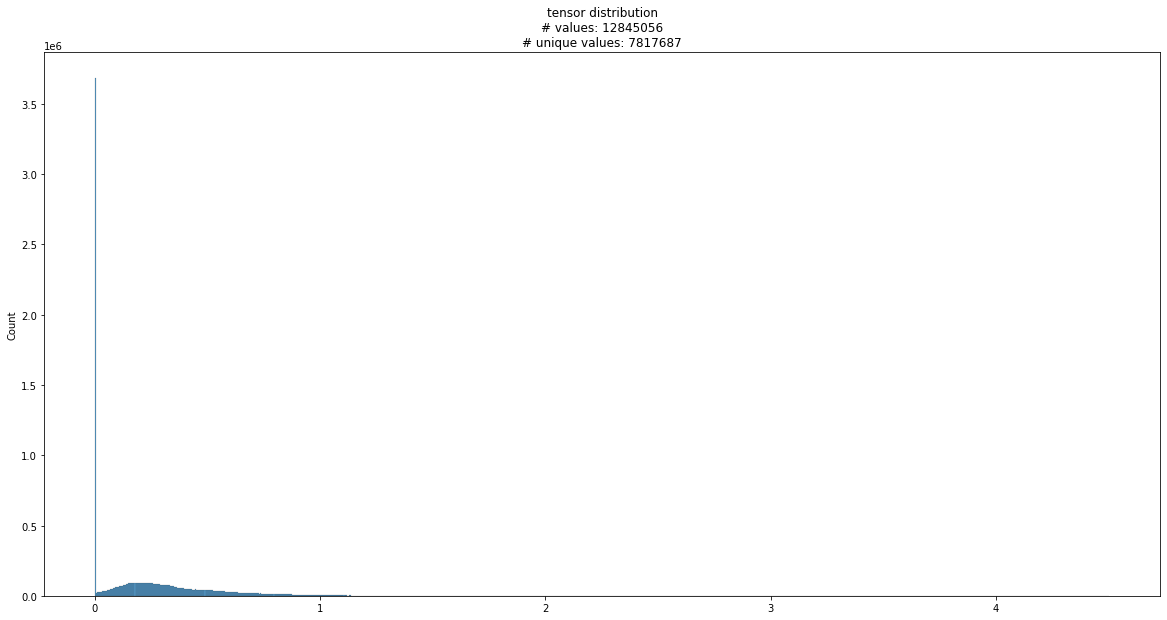

In [8]:
from architectures.Silhouette.components_Silhouette import SilhouetteConv2d

def test_SilhouetteConv2d(auxnet):
    print(f'**SilhouetteConv2d test**')
    
    policy = '2bit 50%, 3bit 30%, 4bit 20%'
    in_channels = 64
    out_channels = 128
    
    print(f'simiulate layer1.0.conv1: policy: {policy}, in_channels: {in_channels}, out_channels: {out_channels}, options: weight_scaling(X), interpolate before sectioning(X)')
    layer = SilhouetteConv2d(policy, in_channels, out_channels)
    assert layer.silhouette is None
    layer.silhouette = auxnet.silhouette
    assert layer.silhouette is not None
    
    print(f'mask generated:')
    masks, quantile_values = layer._generate_masks(feature_maps['before_layer1'].shape[-2:])
    visualize_tensor(integrate_mask(masks))
    visualize_tensor_distribution(masks, is_mask=True)
    print()
    
#     print(f'quantized weights in conv layer:')
#     for nbit, conv in layer.conv_layers.items():
#         print(f'    bit-width: {nbit}')
#         visualize_tensor_distribution(conv.quant_weight().value)
        
    y, x_quants = layer(feature_maps['before_layer1'], debug=True)
#     visualize_tensor_distribution(y)
    print(x_quants)

    for nbit, x_quant in x_quants.items():
        print(f'{nbit}bit region\'s value distribution including masked value')
        visualize_tensor_distribution(x_quant)
    
test_SilhouetteConv2d(auxnet)

In [9]:
def test_SilhouetteConv2d_interpolate_before_vs_after_sectioning(auxnet):
    print(f'**SilhouetteConv2d interpolate before vs after sectioning**')
    
    policy = '2bit 50%, 3bit 30%, 4bit 20%'
    in_channels = 128
    out_channels = 256
    print(f'simiulate layer2.0.conv1: policy: {policy}, in_channels: {in_channels}, out_channels: {out_channels}')
    
    layer_before = SilhouetteConv2d(policy, in_channels, out_channels, interpolate_before_sectioning=True)
    layer_before.silhouette = auxnet.silhouette
    masks_before = layer_before._generate_masks(feature_maps['before_layer1'].shape[-2:])
    print(f'mask interpolated before sectioning: ')
    visualize_tensor(integrate_mask(masks_before))
    visualize_tensor_distribution(masks_before, is_mask=True)
    
    layer_after = SilhouetteConv2d(policy, in_channels, out_channels, interpolate_before_sectioning=False)
    layer_after.silhouette = auxnet.silhouette
    masks_after = layer_after._generate_masks(feature_maps['before_layer1'].shape[-2:])
    print(f'mask interpolated after sectioning: ')
    visualize_tensor(integrate_mask(masks_after))
    visualize_tensor_distribution(masks_after, is_mask=True)
    
test_SilhouetteConv2d_interpolate_before_vs_after_sectioning(auxnet)

**SilhouetteConv2d interpolate before vs after sectioning**
simiulate layer2.0.conv1: policy: 2bit 50%, 3bit 30%, 4bit 20%, in_channels: 128, out_channels: 256
mask interpolated before sectioning: 


AttributeError: 'NoneType' object has no attribute 'detach'

## Models

### ResNet

In [ ]:
from brevitas.nn import QuantConv2d
from architectures.common.components_common import *
from architectures.Silhouette.components_Silhouette import *
from architectures.Silhouette.models.resnet_Silhouette import resnet18_Silhouette

In [ ]:
target_dataset = "ImageNet"
num_classes = 1000

model_config = {
    "backbone": "resnet18",
    "variation": "Silhouette",
    "config": {
        "aux_nets": {
            "A": {
                "extractor_config": {"in_channels": 64, "out_channels": num_classes},
                "compress_config": {"method": "topk_deviation_of_activation", "k": 5},
                "trigger": "layer1",
                "receivers": ["layer1"]
            },
            "B": {
                "extractor_config": {"in_channels": 64, "out_channels": num_classes},
                "compress_config": {"method": "max"},
                "trigger": "layer2",
                "receivers": ["layer2"]
            },
            "C": {
                "extractor_config": {"in_channels": 128, "out_channels": num_classes},
                "compress_config": {"method": "random"},
                "trigger": "layer3",
                "receivers": ["layer3"]
            }
        },
        "layers": {
            "layer1": {
                "sectioning_policy": "2bit 50%, 3bit 50%",
                "weight_scaling_per_output_channel": True,
                "interpolate_before_sectioning": True
            },
            "layer2": {
                "sectioning_policy": "2bit 80%, 3bit 20%",
                "weight_scaling_per_output_channel": True,
                "interpolate_before_sectioning": True
            },
            "layer3": {
                "sectioning_policy": "2bit 50%, 3bit 25%, 4bit 15%, 5bit 10%",
                "weight_scaling_per_output_channel": True,
                "interpolate_before_sectioning": True
            },
            "layer4": {
                "weight_bit_width": 4,
                "activation_bit_width": 4
            }
        }
    }
}
model = resnet18_Silhouette(target_dataset, model_config['config'])

#### Verify Silhouette model has well-made by configuration

In [ ]:
def print_model(model):
    for name, m in model.named_modules():
        if type(m) == SilhouetteConv2d:
            print(f'{name}: SilhouetteConv2d({m.sectioning_policy})')
        elif type(m) == QuantConv2d and not 'conv_layers' in name:
            print(f'{name}: QuantConv2d({m.quant_weight().bit_width})')
        elif type(m) == QuantConv2d:
            print(f'    ㄴ{name}: QuantConv2d({m.quant_weight().bit_width})')
        elif type(m) == QuantPACTReLU:
            print(f'{name}: QuantPACTReLU({m.quant_act_bit_width().item()})')
        
            
print_model(model)

#### Iterate new-made Silhouette model - no silhouette initialized for each layer

In [ ]:
def iterate_Silhouette_model(model):
    for name, m in model.named_modules():
        if type(m) == SilhouetteConv2d:
            if m.silhouette is None:
                print(f'{name}: No stored silhouette')
            else:
                print(f'{name}: Stored silhouette size: {m.silhouette.size()}')
    
iterate_Silhouette_model(model)

#### forward Silhouette model and check activate order between layers and aux_nets

In [ ]:
def forward_Silhouette_model_and_check_activate_order(model, config):
    def activate_alert(modulename):
        def hook(M, I, O):
            print(f'{modulename} activated!')
        return hook
    
    handlers = []
            
    for name, auxnet in model.aux_nets.items():
        handlers.append(auxnet.register_forward_hook(activate_alert(name)))
        triggername = config['aux_nets'][name]['trigger']
        handlers.append(getattr(model, triggername).register_forward_hook(activate_alert(triggername)))
        
    model(sample['batch']['images'])
    
    for handler in handlers:
        handler.remove()
        
forward_Silhouette_model_and_check_activate_order(model, model_config['config'])

#### Iterate Silhouette model that forwarded - silhouettes stored in each layer

In [ ]:
iterate_Silhouette_model(model)

#### check layer-wise stored silhouettes and generated masks(based on passed silhouette)

In [ ]:
# due to a lot of pictures, we will see only some of layers.
def check_layerwise_stored_silhouettes_and_generated_masks(model, config):
    print(f'layer1.0.conv1')
    print('silhouette(compressed attention map)')
    visualize_tensor(model.layer1[0].conv1.silhouette)
    visualize_tensor_distribution(model.layer1[0].conv1.silhouette)
    print('masks')
    visualize_tensor(integrate_mask(model.layer1[0].conv1._generate_masks((64, 64))))
    visualize_tensor_distribution(model.layer1[0].conv1._generate_masks((64, 64)), is_mask=True)
    print()
    
    print(f'layer2.0.conv1')
    print('silhouette(compressed attention map)')
    visualize_tensor(model.layer2[0].conv1.silhouette)
    visualize_tensor_distribution(model.layer2[0].conv1.silhouette)
    print('masks')
    visualize_tensor(integrate_mask(model.layer2[0].conv1._generate_masks((64, 64))))
    visualize_tensor_distribution(model.layer2[0].conv1._generate_masks((64, 64)), is_mask=True)
    print()
    
    print(f'layer3.0.conv1')
    print('silhouette(compressed attention map)')
    visualize_tensor(model.layer3[0].conv1.silhouette)
    visualize_tensor_distribution(model.layer3[0].conv1.silhouette)
    print('masks')
    visualize_tensor(integrate_mask(model.layer3[0].conv1._generate_masks((128, 128))))
    visualize_tensor_distribution(model.layer3[0].conv1._generate_masks((128, 128)), is_mask=True)
    print()
    
check_layerwise_stored_silhouettes_and_generated_masks(model, model_config['config'])